In [56]:
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import rc
rc("font", family = "Malgun Gothic")
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import mean_squared_error, mean_squared_log_error 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [3]:
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label) 
            marker_idx = label % len(markers)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[marker_idx], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        #axs[ind].legend(loc='upper right')
    
    plt.show()

In [61]:
clusterdata = pd.read_pickle("../dataset/clusterdata.pkl")
clusterdata

,성별,연령대,거주지역,A구매여부,B구매여부,C구매여부,D구매여부,선호제휴사,선호제휴점포,선호상품1,선호상품2,선호상품3,R,F,M,CAGR,LABEL,가공변화,신선변화,일상변화,의약변화,교육변화,디지털변화,가구변화,의류변화,전문스포츠변화,패션잡화변화,명품변화,기타변화,ABS가공,ABS신선,ABS일상,ABS의약,ABS교육,ABS디지털,ABS가구,ABS의류,ABS전문스포츠,ABS패션잡화,ABS명품,ABS기타
0,1,0,7,1,1,1,0,0,3,4,1,3,3,3,0,0,1,-6,0,-1,0,0,-7,0,-1,6,0,-8,0,6,14,17,14,0,29,20,1,12,18,24,2
1,1,0,7,1,1,0,1,0,44,9,10,4,3,3,0,0,1,0,0,0,0,0,-9,0,0,-1,-2,0,-9,14,2,0,18,0,45,34,4,5,8,18,25
2,1,0,7,1,1,1,0,2,419,6,0,9,2,4,9,4,0,-2,-3,0,0,0,-8,0,0,0,3,0,-2,4,5,4,0,0,8,0,0,0,3,0,4
3,0,0,7,1,1,1,0,0,12,3,10,6,7,2,5,1,1,3,2,-5,0,0,0,-8,-2,-8,-2,0,3,13,6,9,14,0,0,26,4,12,12,16,29
4,1,0,7,1,1,0,1,0,44,0,1,6,2,1,6,7,0,2,-1,-1,0,0,0,-9,1,-6,-2,0,0,28,11,23,12,0,0,9,23,6,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19378,0,4,7,1,1,1,1,3,651,8,9,11,1,0,9,7,0,1,0,5,9,0,0,0,5,0,5,8,0,1,0,7,13,0,16,0,11,0,21,8,12
19379,0,4,7,1,1,1,1,3,667,9,8,0,5,0,9,8,0,2,0,9,7,0,8,0,0,0,0,0,3,2,2,13,23,16,24,0,0,0,8,0,3
19380,0,2,6,1,1,1,0,1,58,8,6,0,5,2,9,8,0,6,7,5,7,0,0,6,0,0,3,0,4,8,11,5,9,0,0,10,12,10,7,0,8
19381,0,1,6,1,1,1,0,1,58,8,6,0,5,2,9,7,0,7,6,1,8,0,0,6,2,0,4,0,5,7,6,3,10,0,0,18,10,12,12,0,5


In [38]:
clusterdata[clusterdata['LABEL']==1].count()

성별          6920
연령대         6920
거주지역        6920
A구매여부       6920
B구매여부       6920
C구매여부       6920
D구매여부       6920
선호제휴사       6920
선호제휴점포      6920
선호상품1       6920
선호상품2       6920
선호상품3       6920
R           6920
F           6920
M           6920
CAGR        6920
LABEL       6920
가공변화        6920
신선변화        6920
일상변화        6920
의약변화        6920
교육변화        6920
디지털변화       6920
가구변화        6920
의류변화        6920
전문스포츠변화     6920
패션잡화변화      6920
명품변화        6920
기타변화        6920
ABS가공       6920
ABS신선       6920
ABS일상       6920
ABS의약       6920
ABS교육       6920
ABS디지털      6920
ABS가구       6920
ABS의류       6920
ABS전문스포츠    6920
ABS패션잡화     6920
ABS명품       6920
ABS기타       6920
dtype: int64

In [5]:
# column_list = clusterdata.drop(["CAGR", "M", "ABS기타", "ABS가구", "ABS가공" "LABEL"], axis = 1)
# column_list.columns

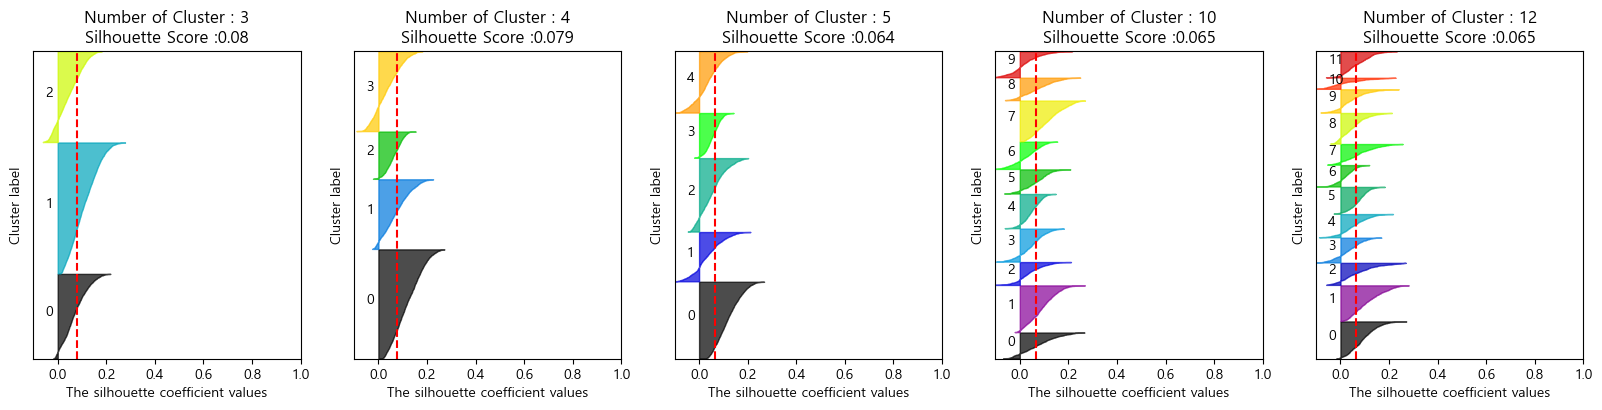

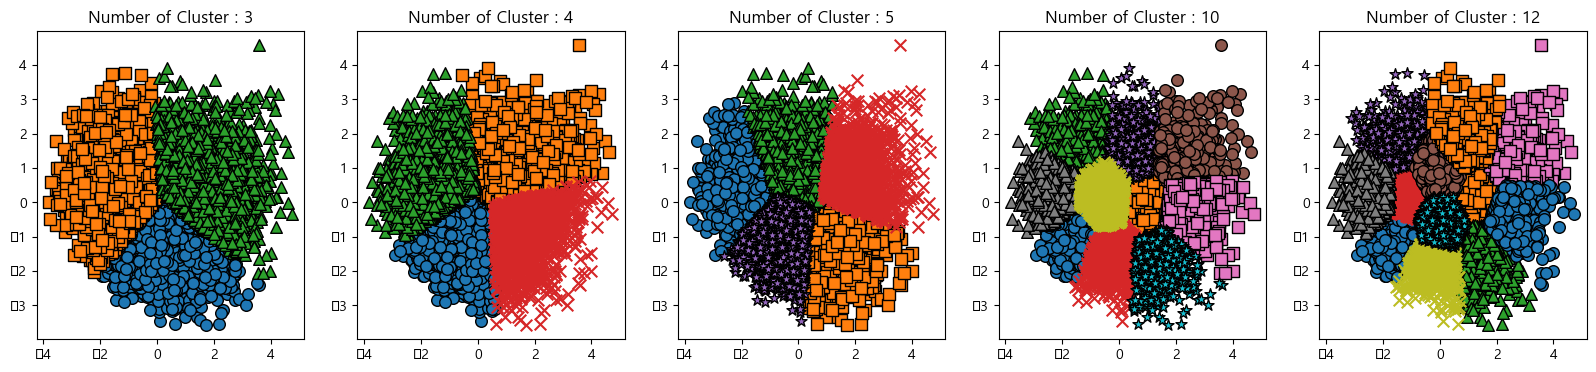

In [6]:
data = clusterdata[clusterdata["LABEL"] == 1]


# 이 부분은 기본 피쳐 부분입니다. 웬만하면 건드리시면 안 됩니다!!
Basic = data[["CAGR", "M", "ABS기타", "ABS가구", "ABS가공"]]
# 이 부분은 기본 피쳐 부분입니다. 웬만하면 건드리시면 안 됩니다!!


#이 부분 수정하시면 됩니다.
Additional = data[["성별","연령대","거주지역", "R", "F", "선호상품1", "선호상품2","기타변화", "가구변화","가공변화"]]
n_cluster = [3,4,5,10,12]
#이 부분 수정하시면 됩니다.




X_features = pd.concat([Basic, Additional], axis = 1)




X_features_scaled = StandardScaler().fit_transform(X_features)

# kmeans = KMeans(n_clusters = 3, random_state = 0)
# labels = kmeans.fit_predict(X_features_scaled)
# data["cluster_label"] = labels



visualize_silhouette(n_cluster, X_features_scaled)
visualize_kmeans_plot_multi(n_cluster, X_features_scaled)

In [7]:
kmeans = KMeans(n_clusters = 3, max_iter=500, random_state=0).fit(X_features)

X_features["cluster"] = kmeans.labels_

In [8]:
X_features

,CAGR,M,ABS기타,ABS가구,ABS가공,성별,연령대,거주지역,R,F,선호상품1,선호상품2,기타변화,가구변화,가공변화,cluster
0,0,0,2,20,6,1,0,7,3,3,4,1,0,0,-6,1
1,0,0,25,34,14,1,0,7,3,3,9,10,-9,0,0,2
3,1,5,29,26,13,0,0,7,7,2,3,10,3,-8,3,2
5,2,3,12,26,9,0,0,0,8,6,11,6,0,6,1,1
9,3,4,12,22,3,0,0,7,8,9,8,6,0,-6,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19356,1,8,16,12,7,0,2,5,5,4,0,8,4,0,-1,2
19358,2,9,4,0,7,1,1,7,5,4,0,6,-4,0,-1,0
19359,3,9,0,0,4,0,1,7,0,0,8,9,0,0,-2,0
19363,3,5,14,0,2,0,3,10,7,2,8,9,-4,0,0,0


In [9]:
cluster0 = X_features[X_features["cluster"] == 0]
cluster1 = X_features[X_features["cluster"] == 1]
cluster2 = X_features[X_features["cluster"] == 2]

In [10]:
def make_pie(df, column):
    count = df[column].value_counts().sort_index()
    index = list(count.index)
    value = list(count)
    
    a = plt.pie(value, labels=index, autopct='%1.1f%%')
    plt.title(f"DataFrame {column} Cluster Pie Chart")

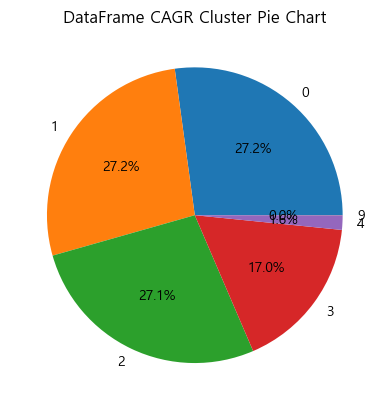

In [11]:
make_pie(X_features, "CAGR")

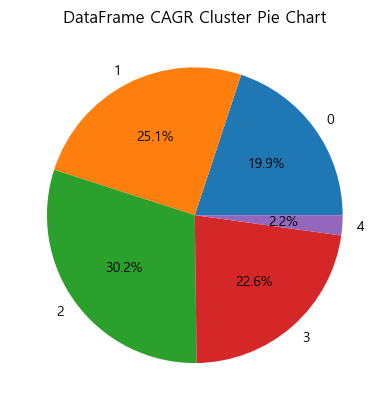

In [12]:
make_pie(cluster0, "CAGR")

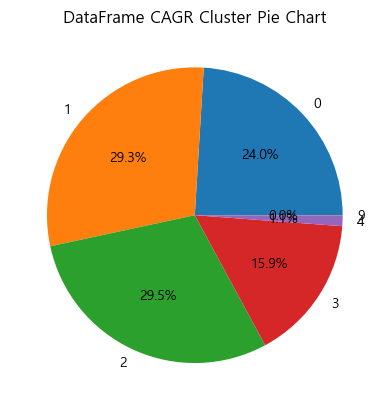

In [13]:
make_pie(cluster1, "CAGR")

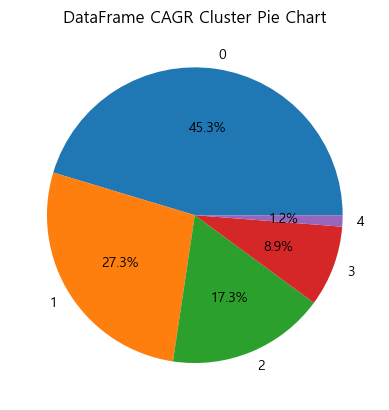

In [14]:
make_pie(cluster2, "CAGR")

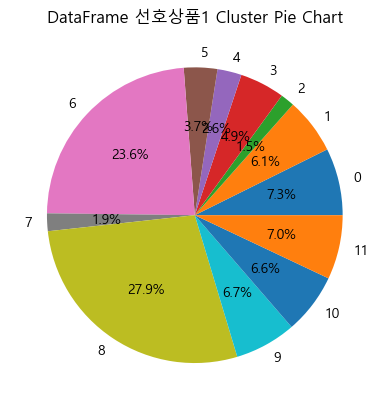

In [15]:
make_pie(X_features, "선호상품1")

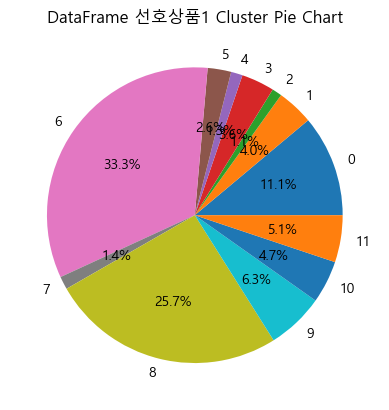

In [16]:
make_pie(cluster0, "선호상품1")

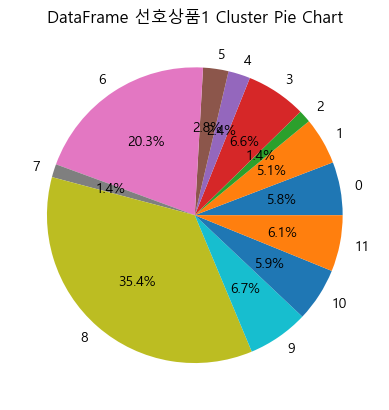

In [17]:
make_pie(cluster1, "선호상품1")

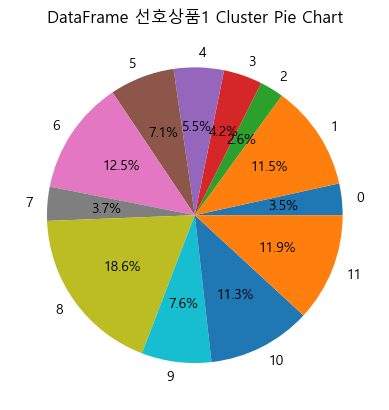

In [18]:
make_pie(cluster2, "선호상품1")

In [22]:
cluster0

,CAGR,M,ABS기타,ABS가구,ABS가공,성별,연령대,거주지역,R,F,선호상품1,선호상품2,기타변화,가구변화,가공변화,cluster
17,0,0,20,0,7,0,0,10,3,1,7,6,-6,0,1,0
36,0,1,0,6,0,0,0,7,9,4,10,9,0,6,0,0
46,0,4,4,7,13,0,0,7,8,6,6,0,-2,-7,-3,0
49,1,3,14,5,9,0,0,7,2,6,11,6,0,-1,-1,0
62,3,9,17,0,5,0,0,7,5,0,6,0,-7,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19354,3,9,0,0,4,0,4,7,3,0,8,9,0,0,0,0
19358,2,9,4,0,7,1,1,7,5,4,0,6,-4,0,-1,0
19359,3,9,0,0,4,0,1,7,0,0,8,9,0,0,-2,0
19363,3,5,14,0,2,0,3,10,7,2,8,9,-4,0,0,0


In [29]:
cluster2.describe()

,CAGR,M,ABS기타,ABS가구,ABS가공,성별,연령대,거주지역,R,F,선호상품1,선호상품2,기타변화,가구변화,가공변화,cluster
count,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.0
mean,0.933550,2.734202,21.016287,19.287296,10.395440,0.157655,1.334202,6.686645,3.865798,3.104235,6.487948,6.609121,0.104235,-1.082736,-1.357003,2.0
std,1.043144,2.415124,5.294618,7.565546,6.162138,0.364536,0.929579,2.352324,3.317053,2.390949,3.350604,3.641127,4.849181,5.273392,3.309577,0.0
min,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.000000,-9.000000,-9.000000,2.0
25%,0.000000,1.000000,17.000000,14.000000,6.000000,0.000000,1.000000,6.000000,1.000000,1.000000,4.000000,4.000000,-3.000000,-6.000000,-3.000000,2.0
50%,1.000000,2.000000,20.000000,18.000000,9.000000,0.000000,1.000000,7.000000,3.000000,3.000000,7.000000,7.000000,0.000000,0.000000,-1.000000,2.0
75%,2.000000,4.000000,24.000000,25.000000,13.000000,0.000000,2.000000,7.000000,8.000000,5.000000,9.000000,10.000000,4.000000,0.000000,1.000000,2.0
max,4.000000,9.000000,45.000000,45.000000,44.000000,1.000000,4.000000,15.000000,9.000000,9.000000,11.000000,11.000000,9.000000,9.000000,9.000000,2.0


In [58]:
X_features

,CAGR,M,ABS기타,ABS가구,ABS가공,성별,연령대,거주지역,R,F,선호상품1,선호상품2,기타변화,가구변화,가공변화,cluster
0,0,0,2,20,6,1,0,7,3,3,4,1,0,0,-6,1
1,0,0,25,34,14,1,0,7,3,3,9,10,-9,0,0,2
3,1,5,29,26,13,0,0,7,7,2,3,10,3,-8,3,2
5,2,3,12,26,9,0,0,0,8,6,11,6,0,6,1,1
9,3,4,12,22,3,0,0,7,8,9,8,6,0,-6,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19356,1,8,16,12,7,0,2,5,5,4,0,8,4,0,-1,2
19358,2,9,4,0,7,1,1,7,5,4,0,6,-4,0,-1,0
19359,3,9,0,0,4,0,1,7,0,0,8,9,0,0,-2,0
19363,3,5,14,0,2,0,3,10,7,2,8,9,-4,0,0,0


In [39]:
cluster0 = X_features[X_features["cluster"] == 0]
cluster1 = X_features[X_features["cluster"] == 1]
cluster2 = X_features[X_features["cluster"] == 2]

Text(0.5, 1.0, '감소예측고객 군집비율')

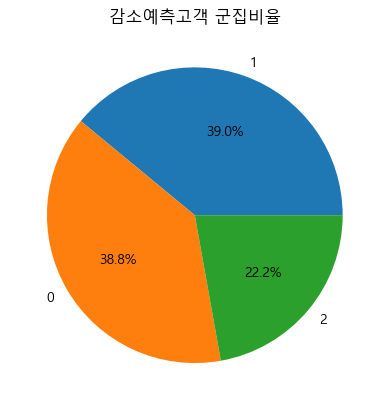

In [49]:
count = X_features.cluster.value_counts()
index = count.index
value = count

a = plt.pie(value, labels=index, autopct='%1.1f%%')
plt.title("감소예측고객 군집비율")

In [53]:
X_features['CAGR'].unique()

array([0, 1, 2, 3, 4, 9], dtype=int64)

In [57]:
clusterdata

,성별,연령대,거주지역,A구매여부,B구매여부,C구매여부,D구매여부,선호제휴사,선호제휴점포,선호상품1,선호상품2,선호상품3,R,F,M,CAGR,LABEL,가공변화,신선변화,일상변화,의약변화,교육변화,디지털변화,가구변화,의류변화,전문스포츠변화,패션잡화변화,명품변화,기타변화,ABS가공,ABS신선,ABS일상,ABS의약,ABS교육,ABS디지털,ABS가구,ABS의류,ABS전문스포츠,ABS패션잡화,ABS명품,ABS기타
0,1,0,7,1,1,1,0,0,3,4,1,3,3,3,0,0,1,-6,0,-1,0,0,-7,0,-1,6,0,-8,0,6,14,17,14,0,29,20,1,12,18,24,2
1,1,0,7,1,1,0,1,0,44,9,10,4,3,3,0,0,1,0,0,0,0,0,-9,0,0,-1,-2,0,-9,14,2,0,18,0,45,34,4,5,8,18,25
2,1,0,7,1,1,1,0,2,419,6,0,9,2,4,9,4,0,-2,-3,0,0,0,-8,0,0,0,3,0,-2,4,5,4,0,0,8,0,0,0,3,0,4
3,0,0,7,1,1,1,0,0,12,3,10,6,7,2,5,1,1,3,2,-5,0,0,0,-8,-2,-8,-2,0,3,13,6,9,14,0,0,26,4,12,12,16,29
4,1,0,7,1,1,0,1,0,44,0,1,6,2,1,6,7,0,2,-1,-1,0,0,0,-9,1,-6,-2,0,0,28,11,23,12,0,0,9,23,6,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19378,0,4,7,1,1,1,1,3,651,8,9,11,1,0,9,7,0,1,0,5,9,0,0,0,5,0,5,8,0,1,0,7,13,0,16,0,11,0,21,8,12
19379,0,4,7,1,1,1,1,3,667,9,8,0,5,0,9,8,0,2,0,9,7,0,8,0,0,0,0,0,3,2,2,13,23,16,24,0,0,0,8,0,3
19380,0,2,6,1,1,1,0,1,58,8,6,0,5,2,9,8,0,6,7,5,7,0,0,6,0,0,3,0,4,8,11,5,9,0,0,10,12,10,7,0,8
19381,0,1,6,1,1,1,0,1,58,8,6,0,5,2,9,7,0,7,6,1,8,0,0,6,2,0,4,0,5,7,6,3,10,0,0,18,10,12,12,0,5


In [62]:
cluster0

,CAGR,M,ABS기타,ABS가구,ABS가공,성별,연령대,거주지역,R,F,선호상품1,선호상품2,기타변화,가구변화,가공변화,cluster
17,0,0,20,0,7,0,0,10,3,1,7,6,-6,0,1,0
36,0,1,0,6,0,0,0,7,9,4,10,9,0,6,0,0
46,0,4,4,7,13,0,0,7,8,6,6,0,-2,-7,-3,0
49,1,3,14,5,9,0,0,7,2,6,11,6,0,-1,-1,0
62,3,9,17,0,5,0,0,7,5,0,6,0,-7,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19354,3,9,0,0,4,0,4,7,3,0,8,9,0,0,0,0
19358,2,9,4,0,7,1,1,7,5,4,0,6,-4,0,-1,0
19359,3,9,0,0,4,0,1,7,0,0,8,9,0,0,-2,0
19363,3,5,14,0,2,0,3,10,7,2,8,9,-4,0,0,0


In [63]:
cluster0['cluster'] 

17       0
36       0
46       0
49       0
62       0
        ..
19354    0
19358    0
19359    0
19363    0
19370    0
Name: cluster, Length: 2685, dtype: int32

In [64]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier

y = cluster0['cluster']
X = cluster0.drop('cluster',axis=1)

dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state = 156)

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=11)

dt_clf.fit(X_train,y_train)

pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
creport = classification_report(y_test, pred)

print(f'결정트리예측 정확도:{accuracy:.4f}','\n')
print(f'classification report:\n{creport}')

결정트리예측 정확도:1.0000 

classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537

    accuracy                           1.00       537
   macro avg       1.00      1.00      1.00       537
weighted avg       1.00      1.00      1.00       537



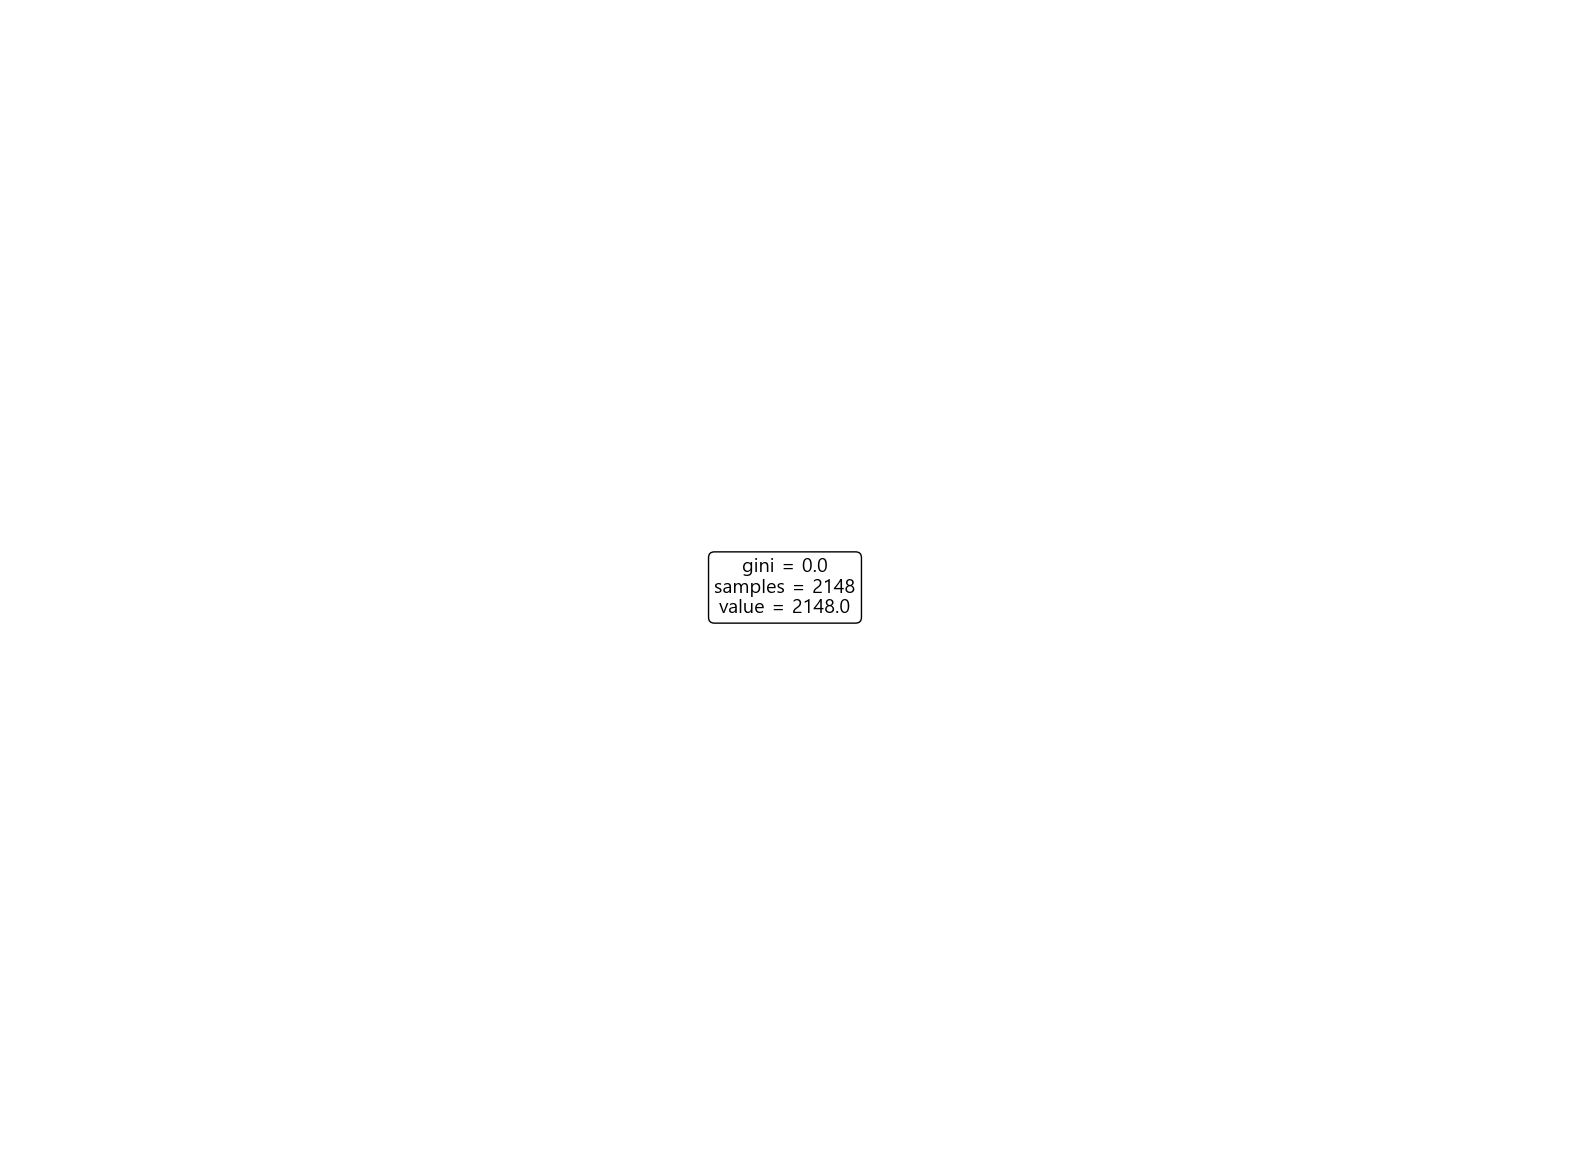

In [72]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize = (20,15))
tree.plot_tree(dt_clf, filled=True,
               feature_names=X.columns,
               class_names=y.unique(), rounded=True, fontsize=14)
plt.show()
plt.close()

In [79]:
customerdata = pd.read_pickle('../dataset/customerdata.pkl')
customerdata.head(1)

,고객번호,성별,연령대,거주지역,A선호점포,B선호점포,C선호점포,D선호점포,선호제휴사,선호점포,선호제휴점포,14_1분기,14_2분기,14_3분기,14_4분기,15_1분기,15_2분기,15_3분기,15_4분기,14_2분기변화,14_3분기변화,14_4분기변화,15_1분기변화,15_2분기변화,15_3분기변화,15_4분기변화,최근성,행동 빈도,구매 총액,평균구매액,분기 총변화,감소고객,R 등급,F 등급,M 등급,AM 등급,14_2변화율,14_3변화율,14_4변화율,15_1변화율,15_2변화율,15_3변화율,15_4변화율
0,00752,M,60세이상,440,14.0,NaN,NaN,NaN,A,14,A14,8204832.0,3889436.0,4091932.0,3373364.0,4700689.0,5258195.0,7600201.0,7109948.0,-4249130.0,129630.0,-507900.0,1161230.0,577830.0,2195220.0,-70140.0,1,627,44120440,70367.53,-763260.0,1,1,10,4,3,47.4,105.21,82.44,139.35,111.86,144.54,93.55


In [80]:
clusterdata

,성별,연령대,거주지역,A구매여부,B구매여부,C구매여부,D구매여부,선호제휴사,선호제휴점포,선호상품1,선호상품2,선호상품3,R,F,M,CAGR,LABEL,가공변화,신선변화,일상변화,의약변화,교육변화,디지털변화,가구변화,의류변화,전문스포츠변화,패션잡화변화,명품변화,기타변화,ABS가공,ABS신선,ABS일상,ABS의약,ABS교육,ABS디지털,ABS가구,ABS의류,ABS전문스포츠,ABS패션잡화,ABS명품,ABS기타
0,1,0,7,1,1,1,0,0,3,4,1,3,3,3,0,0,1,-6,0,-1,0,0,-7,0,-1,6,0,-8,0,6,14,17,14,0,29,20,1,12,18,24,2
1,1,0,7,1,1,0,1,0,44,9,10,4,3,3,0,0,1,0,0,0,0,0,-9,0,0,-1,-2,0,-9,14,2,0,18,0,45,34,4,5,8,18,25
2,1,0,7,1,1,1,0,2,419,6,0,9,2,4,9,4,0,-2,-3,0,0,0,-8,0,0,0,3,0,-2,4,5,4,0,0,8,0,0,0,3,0,4
3,0,0,7,1,1,1,0,0,12,3,10,6,7,2,5,1,1,3,2,-5,0,0,0,-8,-2,-8,-2,0,3,13,6,9,14,0,0,26,4,12,12,16,29
4,1,0,7,1,1,0,1,0,44,0,1,6,2,1,6,7,0,2,-1,-1,0,0,0,-9,1,-6,-2,0,0,28,11,23,12,0,0,9,23,6,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19378,0,4,7,1,1,1,1,3,651,8,9,11,1,0,9,7,0,1,0,5,9,0,0,0,5,0,5,8,0,1,0,7,13,0,16,0,11,0,21,8,12
19379,0,4,7,1,1,1,1,3,667,9,8,0,5,0,9,8,0,2,0,9,7,0,8,0,0,0,0,0,3,2,2,13,23,16,24,0,0,0,8,0,3
19380,0,2,6,1,1,1,0,1,58,8,6,0,5,2,9,8,0,6,7,5,7,0,0,6,0,0,3,0,4,8,11,5,9,0,0,10,12,10,7,0,8
19381,0,1,6,1,1,1,0,1,58,8,6,0,5,2,9,7,0,7,6,1,8,0,0,6,2,0,4,0,5,7,6,3,10,0,0,18,10,12,12,0,5


In [81]:
cluster0

,CAGR,M,ABS기타,ABS가구,ABS가공,성별,연령대,거주지역,R,F,선호상품1,선호상품2,기타변화,가구변화,가공변화,cluster
17,0,0,20,0,7,0,0,10,3,1,7,6,-6,0,1,0
36,0,1,0,6,0,0,0,7,9,4,10,9,0,6,0,0
46,0,4,4,7,13,0,0,7,8,6,6,0,-2,-7,-3,0
49,1,3,14,5,9,0,0,7,2,6,11,6,0,-1,-1,0
62,3,9,17,0,5,0,0,7,5,0,6,0,-7,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19354,3,9,0,0,4,0,4,7,3,0,8,9,0,0,0,0
19358,2,9,4,0,7,1,1,7,5,4,0,6,-4,0,-1,0
19359,3,9,0,0,4,0,1,7,0,0,8,9,0,0,-2,0
19363,3,5,14,0,2,0,3,10,7,2,8,9,-4,0,0,0


In [82]:
def make_pie(df, column, num = None):
    
    gender = {0 : "F", 1 : "M"}
    age = {0 : '노년층', 1 : '장년층', 2 : '중년층', 3 : '청년층', 4 : '학생층'}
    region = {0 : '강원', 1 : '경남', 2 : '경북', 3 : '광주', 4 : '대구', 5 : '대전', 6 : '부산', 7 : '서울', 8 : '세종', 9 : '울산',
            10 : '인천', 11 : '전남', 12 : '전북', 13 : '제주', 14 : '충남', 15 : '충북'}
    product = {0 : '가공', 1 : '가구', 2 : '교육', 3 : '기타', 4 : '디지털', 5 : '명품', 6 : '신선', 7 : '의류', 8 : '의약', 9 : '일상',
            10 : '전문스포츠', 11 : '패션잡화'}
    jehu = {0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D'}
    
    
    count = df[column].value_counts().sort_index()
    index = list(count.index)
    value = list(count)
    
    label = []
    if column == "성별" :
        for i in index:
            label.append(gender[i])
        index = label
    elif column == "연령대" :
        for i in index:
            label.append(age[i])
        index = label
    elif column == "거주지역" :
        for i in index:
            label.append(region[i])
        index = label
    elif column in ["선호상품1", "선호상품2", "선호상품3"]:
        for i in index:
            label.append(product[i])
        index = label
    elif column == "선호제휴사" :
        for i in index:
            label.append(jehu[i])
        index = label
        
    if num:
        index = index[:num]
        value = value[:num]
    
    a = plt.pie(value, labels=index, autopct='%1.1f%%')
    plt.title(f"DataFrame {column} Cluster Pie Chart")

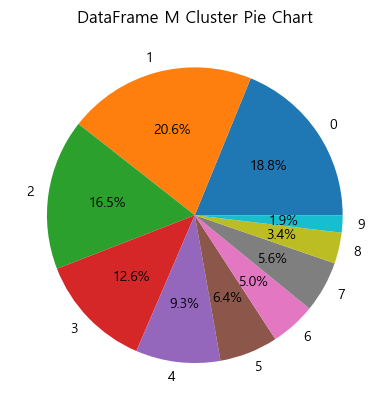

In [83]:
make_pie(cluster2,"M",10)